<img src="https://www.research.hsbc.com/A/MultiAssetHeatmap/etc/HSBC_GR_Logo_New.png" style="width:300px;margin-top:10px" align="left"/>
<a href="https://www.research.hsbc.com/C/1/1/323/PnwFQ9T"><img src="https://www.research.hsbc.com/A/MultiAssetHeatmap/etc/DataScienceBanner.jpg" style="width:310px;margin-top:3px" align="right"/></a>

# Comparing XGBoost and LightGBM
__N.B.__ In this notebook we focus on a family of supervised machine learning models called Ensembles of Decision Trees. We have used such techniques extensively in our previous publications. A few of them are linked below: <br/>
Link ----> <a href="https://www.research.hsbc.com/R/36/NkbRXVQC2Rnf">Machine Learning 102</a><br/>
Link ----> <a href="https://www.research.hsbc.com/R/36/6ftWmDlC2Rnf">Predicting Pullbacks</a><br/>
Link ----> <a href="https://www.research.hsbc.com/R/36/TWBkB7XC2Rnf">Global Credit Strategy: 2020 and Beyond</a><br/>
__Get in touch with HSBC Data Science Team__ <br/>
Link ----> <a href="https://www.research.hsbc.com/C/1/1/323/PnwFQ9T">https://www.research.hsbc.com/C/1/1/323/PnwFQ9T</a>

XGBoost and LightGBM are both ensembles of gradient boosted decision trees. However, the mechanics of how these models build up the trees in the ensemble mean that there are important differences betwen them.

In this notebook we use both XGBoost and LightGBM to build a classification model for a publically available dataset. The dataset is taken from this Kaggle competition: <href> https://www.kaggle.com/mlg-ulb/creditcardfraud </href><br/>
If this link is not accessible from your corporate environment, it is available on serveral github repos. Ask us and we can point you to one.
#### Data
The data contains information about credit card transactions and the task is to predict whether the transactions are fraudulent or not.

The dataset contains 30 features and the variable to predict is a binary outcome: 1 (fraud) or 0 (not fraud). 28 of the features are principal components of the original data; the original data was clearly too sensitive to release to the public.

### Instructions to run this notebook 
1. Create a virtualenv - virtualenv ENVNAME
2. source activate ENVNAME
3. pip install ipykernel
4. python -m ipykernel install --user --name ENVNAME --display-name "Python (whatever you want to call it)"
5. pip Install the following versions of the packages:<br>pandas==0.24.2<br> numpy==1.16.2 <br> scikit-learn==0.21.2 <br>scikit-image==0.14.2<br> matplotlib==3.0.3 <br>scipy==1.2.1<br>lightgbm==2.2.3<br> xgboost==0.82 <br> shap==0.30.1<br> bayesian-optimization==1.0.1<br>
6. with the new environment - open jupyter  

In [1]:
#Importing the required libraries
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
import lightgbm as lgb

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV
import bayes_opt as bayso

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report, confusion_matrix,log_loss,roc_auc_score,auc,precision_recall_curve

import matplotlib.pyplot as plt 
from utils import pretty_confusion_matrix
import time

#### Loading credit card transactions into a Pandas Dataframe

In [2]:
data = pd.read_csv("creditcard.csv")
# Remove the column Time as its not required
data.drop(columns=['Time'],axis=1, inplace=True)

In [3]:
# have a quick look to see if the dataframe seems sensible
data.shape

(284807, 30)

In [4]:
# Look at the distribution of your dependent variable.
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

#### Create the training data

In [5]:
# Keep all the independent variables in X and the dependent variable in y
X = data.iloc[:,:-1]
y= data.iloc[:,-1]

# Carry out a 80-20 train-test split
X_train, X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Check the distribution of the dependent variable in train and test data
print(y_train.value_counts())
print(y_test.value_counts())

0    227451
1       394
Name: Class, dtype: int64
0    56864
1       98
Name: Class, dtype: int64


## The comparison
We will compare three models throughout this notebook:<ol>
    <li> XGBoost
    <li> XGBoost (with same tree-growing policy as LightGBM)
    <li> LightGBM
</ol>        
We have selected two avenues for comparision: <b>Speed and Performance</b>

Initially we will fit "comparable" models for each of these and time how long it takes to fit the model to our training data. We will then do an extensive hyperparameter search and compare performance of these three models when they are at their best. <br>
**N.B. Because of the different ways in which XGBoost and LightGBM build the constitutent trees we need to specify the maximum number of leaves to be 2^*max_depth* in order to have comparable calculation complexity.**

This data set has a very noticeable __class imbalance__ (there are vastly more examples of Class 0 than there are of Class 1). There are several methods which can be used in order to combat this imbalance. We have discussed this topic in a previous edition of IDSL. Please contact us if you missed that. <br>
For binary models in both XGBoost and LightGBM, there is an easy way to balance the classes by increasing the weight on negative class(less instances) using a parameter called *scale_pos_weight*.

## Speed
__Timing our Models__<br>
We can profile our code to check how long it takes to fit the three models. In Jupyter, this can be done  using magic commands which start with "%%"

In [7]:
import multiprocessing
coresavailable = multiprocessing.cpu_count()
print("Number of cores Available: " , coresavailable)

Number of cores Available:  12


__N.B.__ Number of available cores is to check how many cores are available to multiprocess all these models. When running this notebook, please update n_jobs (below) as required to maintain your computers usability. Generally, 2-3 cores can be left idle so you can use your machine while these models learn.

In [8]:
#Model Parameters
max_depth = 3 # Max depth for base trees
lr = 0.1 # Learning rate for the algorithm
Ne = 250 # Number of boosted trees to fit
njobs = coresavailable - 4 # This corresponds to number of cores to run on you have.Please change as required
## FIX FOR CLASS IMBALANCE
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

In [9]:
#Initialize the three models
xgbc = XGBClassifier(max_depth=max_depth, n_jobs=njobs, learning_rate=lr, scale_pos_weight=scale_pos_weight,
                    n_estimators=Ne,verbose=False)
hist_xgbc = XGBClassifier(max_depth=max_depth,n_jobs=njobs, learning_rate=lr, scale_pos_weight=scale_pos_weight,
                    n_estimators=Ne, tree_method ='hist',grow_policy='lossguide',verbose=False)
lgbmc = LGBMClassifier(num_leaves = 2**max_depth,n_jobs=njobs, learning_rate=lr, scale_pos_weight=scale_pos_weight,
                      n_estimators=Ne,)

In [10]:
%%time
xgbc.fit(X_train,y_train)

Wall time: 31.6 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=250,
              n_jobs=8, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=577.2868020304569, seed=None, silent=True,
              subsample=1, verbose=False)

In [11]:
%%time
hist_xgbc.fit(X_train,y_train)

Wall time: 5.49 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, grow_policy='lossguide',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=250, n_jobs=8,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=577.2868020304569,
              seed=None, silent=True, subsample=1, tree_method='hist',
              verbose=False)

In [12]:
%%time
lgbmc.fit(X_train,y_train)

Wall time: 1.81 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=250, n_jobs=8, num_leaves=8, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               scale_pos_weight=577.2868020304569, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

So we can see that when we do one iteration of fitting the data, __LightGBM is the fastest__, then XGBoost with the same tree-growing policy (best first) as LightGBM, and then XGBoost with the default tree-growing method is slowest (with runtime more than 17 times the runtime of LightGBM).

If all we had to do was fit the model once then this performance difference would not be that dramatic - 36s for the slowest of the models is not a long time. However, a Machine Learning pipeline will typically involve fitting variations of the model several times in order choose values for the model hyperparameters.

## Performance

__Hyperparameter Optimization__ <br>
For each of the three models we will use a  technique called __Bayesian optimisation__ in order to choose good hyperparameters.

__Create Datasets for the Models__<br>
Both XGBoost and LightBGM come with their own data objects to create training data. These objects are optimised for use with these models for faster and more memory efficient results.

In [13]:
# XGBoost Datd Object - DMatrix
xgb_train_data = xgb.DMatrix(X_train, label=y_train)
xgb_test_data = xgb.DMatrix(X_test)
#LightGBM Data Object - Dataset
lgb_train_data = lgb.Dataset(X_train, y_train)
lgb_test_data = lgb.Dataset(X_test, y_test, reference=lgb_train_data)

__Parameter Dictionary__ <br>
We will create dictionaries of parameters that is used for the three algorithms We then optimize these parameters using two functions.

In [14]:
model_type = {}
max_allowed_depth = 10
xgb_param_dict = {'learning_rate':(0.005,0.5),
               'num_boost_round':(100,300),
              'min_child_weight': (0, 20),
              'max_depth': (3, max_allowed_depth),
              'subsample': (0.5, 1.0),
              'reg_alpha': (0, 30),
              'reg_lambda': (0, 40)}

xgb_hist_param_dict = {'learning_rate':(0.005,0.5),
               'num_boost_round':(100,300),
              'min_child_weight': (0, 20),
              'max_depth': (2**3, 2**max_allowed_depth),# Called Max Rounds in ligh GBM
              'subsample': (0.5, 1.0),
              'reg_alpha': (0, 30),
              'reg_lambda': (0, 40)}

lgbm_param_dict = {'learning_rate':(0.005,0.5),
               'num_boost_round':(100,300),
              'min_child_weight': (0, 20),
              'max_depth': (2**3, 2**max_allowed_depth), # Called Num Rounds in ligh GBM
              'subsample': (0.5, 1.0),
              'reg_alpha': (0, 30),
              'reg_lambda': (0, 40)}

__Functions for Hyperparameter Learning__ <br>
The first function below returns the cross-validated performance of the classifier -- this is the variable which we want to optimize using the parameter dictionary. The second function takes the output from the first function and optimizes the model result using the bayesian optimizer package. Abstracting logic in functions like these keeps code clean and more functional.

In [15]:
# Function 1: Return the model cross validation results to be optimized
def model_results_cv(learning_rate, num_boost_round, min_child_weight, max_depth, subsample,
                     reg_alpha, reg_lambda):
    
    params = {}
    #constant parameters
    params['random_state']: 42 
    params['scale_pos_weight']: scale_pos_weight # Defined in the cell at the begining
   
    if model_type['model'] =='XGboost':
        #Setting Hyperparameters to optimize
        params = {
            'objective':'binary:logistic',
            'eval_metric':'logloss',
            'num_boost_round' : int(num_boost_round),
            'nthread': njobs,
            'learning_rate': float(learning_rate),
            'min_child_weight': int(min_child_weight),
            'max_depth': int(max_depth),            
            'subsample': max(min(subsample, 1), 0),
            'reg_alpha': max(reg_alpha,0),
            'reg_lambda': max(reg_lambda,0)
        }                
        cv_result = xgb.cv(params, xgb_train_data,num_boost_round=params['num_boost_round'], nfold=3)
        return (-cv_result['test-logloss-mean'].iloc[-1])
    
    
    if model_type['model'] == 'XGboosthist':  
        params = {
            'objective':'binary:logistic',
            'eval_metric':'logloss',
            'tree_method':'hist',
            'grow_policy':'lossguide',
            'max_bin': 100,
            'nthread': njobs,
            'num_boost_round' : int(num_boost_round),
            'learning_rate': float(learning_rate),
            'min_child_weight': int(min_child_weight),
            'max_leaves': int(max_depth),            
            'subsample': max(min(subsample, 1), 0),
            'reg_alpha': max(reg_alpha,0),
            'reg_lambda': max(reg_lambda,0)
        }                          
        cv_result = xgb.cv(params, xgb_train_data,num_boost_round=params['num_boost_round'], nfold=3)
        return (-cv_result['test-logloss-mean'].iloc[-1])
    
    if model_type['model'] == 'lightgbm':      
        params = {
            'objective':'binary',
            'metric':'binary_logloss',
            'boosting':'gbdt',
            'max_bin': 100,
            'num_threads': njobs,
            'num_boost_round' : int(num_boost_round),
            'min_data_in_leaf': 0,# Setting this to zero because we want comparable models and regularizing with min_child
            'learning_rate': float(learning_rate),
            'min_child_weight': int(min_child_weight),
            'num_leaves': int(max_depth),            
            'subsample': max(min(subsample, 1), 0),
            'reg_alpha': max(reg_alpha,0),
            'reg_lambda': max(reg_lambda,0)
        }                 
        cv_result = lgb.cv(params, lgb_train_data,nfold=3)        
        return (-cv_result['binary_logloss-mean'][-1])
    

In [16]:
# Function 2:Bayesian Optimization For Hyperparamter Opt
def hyperparameter_tuning(classifier, parameters):
    init_points = 15
    numitems= 50
    optimizer = bayso.BayesianOptimization(classifier,parameters, random_state = 20160623)
    optimizer.maximize(init_points=init_points, n_iter=numitems)
    return optimizer

##### Hyperparameter optimization for all three models and calculate time...

In [17]:
start_time = time.time() #This takes about 73 mins on our machine using 8 cores
model_type['model'] ='XGboost'
xgb_optimizer = hyperparameter_tuning(model_results_cv, xgb_param_dict)
print("%.2f minutes" % (int(time.time() - start_time)/60))

|   iter    |  target   | learni... | max_depth | min_ch... | num_bo... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.003113 |  0.1267   |  3.259    |  3.316    |  108.9    |  16.35    |  29.75    |  0.7857   |
|  2        | -0.003235 |  0.2947   |  8.17     |  8.252    |  194.7    |  21.36    |  8.717    |  0.634    |
|  3        | -0.003414 |  0.1991   |  8.561    |  18.56    |  114.7    |  26.08    |  4.932    |  0.7492   |
|  4        | -0.003138 |  0.2957   |  8.932    |  3.971    |  100.6    |  21.66    |  30.83    |  0.7681   |
|  5        | -0.002944 |  0.3284   |  3.499    |  4.461    |  112.7    |  11.54    |  38.3     |  0.9418   |
|  6        | -0.003308 |  0.1414   |  8.408    |  0.714    |  286.8    |  28.9     |  5.278    |  0.6448   |
|  7        | -0.003206 |  0.4917   |  3.995    |  15.25    |  219.0    |  20.31    |  25.01    |  0.9159   |
|  8      

|  45       | -0.003115 |  0.22     |  8.748    |  19.86    |  297.0    |  2.412    |  0.6026   |  0.5202   |
|  46       | -0.002983 |  0.4051   |  4.917    |  19.95    |  297.9    |  0.4772   |  1.954    |  0.8087   |
|  47       | -0.003215 |  0.4076   |  4.515    |  0.1758   |  294.0    |  29.52    |  0.7905   |  0.9097   |
|  48       | -0.003379 |  0.0221   |  3.389    |  0.2419   |  299.3    |  2.586    |  0.251    |  0.9326   |
|  49       | -0.003368 |  0.2971   |  9.767    |  19.48    |  295.9    |  29.48    |  38.8     |  0.9225   |
|  50       | -0.003531 |  0.201    |  6.321    |  20.0     |  100.0    |  26.88    |  0.1521   |  0.5844   |
|  51       | -0.002965 |  0.4744   |  5.679    |  18.13    |  298.0    |  0.3357   |  0.9729   |  0.9049   |
|  52       | -0.003151 |  0.1357   |  7.949    |  19.31    |  298.3    |  1.319    |  39.88    |  0.5425   |
|  53       | -0.002997 |  0.07606  |  9.815    |  19.35    |  296.9    |  1.257    |  2.256    |  0.6847   |
|  54     

In [18]:
start_time = time.time()#This takes about 46 mins on our machine using 8 cores; however, this time it look much longer
model_type['model'] = 'XGboosthist'
histxgb_optimizer = hyperparameter_tuning(model_results_cv, xgb_hist_param_dict)
print("%.2f minutes" % (int(time.time() - start_time)/60))

|   iter    |  target   | learni... | max_depth | min_ch... | num_bo... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.003188 |  0.1267   |  45.59    |  3.316    |  108.9    |  16.35    |  29.75    |  0.7857   |
|  2        | -0.003302 |  0.2947   |  758.4    |  8.252    |  194.7    |  21.36    |  8.717    |  0.634    |
|  3        | -0.003466 |  0.1991   |  815.1    |  18.56    |  114.7    |  26.08    |  4.932    |  0.7492   |
|  4        | -0.003255 |  0.2957   |  869.0    |  3.971    |  100.6    |  21.66    |  30.83    |  0.7681   |
|  5        | -0.002971 |  0.3284   |  80.39    |  4.461    |  112.7    |  11.54    |  38.3     |  0.9418   |
|  6        | -0.003391 |  0.1414   |  792.9    |  0.714    |  286.8    |  28.9     |  5.278    |  0.6448   |
|  7        | -0.003288 |  0.4917   |  152.4    |  15.25    |  219.0    |  20.31    |  25.01    |  0.9159   |
|  8      

|  45       | -0.003634 |  0.5      |  594.1    |  20.0     |  300.0    |  30.0     |  0.0      |  0.5      |
|  46       | -0.1197   |  0.005    |  357.9    |  20.0     |  300.0    |  0.0      |  0.0      |  1.0      |
|  47       | -0.1915   |  0.005    |  459.7    |  20.0     |  213.5    |  30.0     |  0.0      |  0.5      |
|  48       | -0.002687 |  0.5      |  734.7    |  0.0      |  100.0    |  0.0      |  40.0     |  0.5      |
|  49       | -0.002881 |  0.5      |  674.5    |  0.0      |  300.0    |  0.0      |  40.0     |  0.5      |
|  50       | -0.1835   |  0.005    |  557.0    |  0.0      |  221.3    |  0.0      |  40.0     |  0.5      |
|  51       | -0.1204   |  0.005    |  155.3    |  20.0     |  300.0    |  0.0      |  40.0     |  1.0      |
|  52       | -0.2063   |  0.005    |  236.7    |  0.0      |  198.2    |  0.0      |  0.0      |  1.0      |
|  53       | -0.003652 |  0.5      |  1.024e+0 |  20.0     |  177.3    |  30.0     |  40.0     |  0.5      |
|  54     

In [19]:
start_time = time.time()#This takes about 9 mins on our machine using 8 cores
model_type['model'] = 'lightgbm'
lgb_optimizer = hyperparameter_tuning(model_results_cv, lgbm_param_dict)
print("%.2f minutes" % (int(time.time() - start_time)/60))

|   iter    |  target   | learni... | max_depth | min_ch... | num_bo... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.003164 |  0.1267   |  45.59    |  3.316    |  108.9    |  16.35    |  29.75    |  0.7857   |
|  2        | -0.003333 |  0.2947   |  758.4    |  8.252    |  194.7    |  21.36    |  8.717    |  0.634    |
|  3        | -0.003328 |  0.1991   |  815.1    |  18.56    |  114.7    |  26.08    |  4.932    |  0.7492   |
|  4        | -0.003255 |  0.2957   |  869.0    |  3.971    |  100.6    |  21.66    |  30.83    |  0.7681   |
|  5        | -0.003016 |  0.3284   |  80.39    |  4.461    |  112.7    |  11.54    |  38.3     |  0.9418   |
|  6        | -0.003587 |  0.1414   |  792.9    |  0.714    |  286.8    |  28.9     |  5.278    |  0.6448   |
|  7        | -0.003269 |  0.4917   |  152.4    |  15.25    |  219.0    |  20.31    |  25.01    |  0.9159   |
|  8      

|  45       | -0.004212 |  0.005    |  95.25    |  0.0      |  179.8    |  0.0      |  0.0      |  0.5      |
|  46       | -0.006506 |  0.005    |  577.9    |  0.0      |  193.4    |  0.0      |  40.0     |  0.5      |
|  47       | -0.004355 |  0.005    |  73.61    |  20.0     |  300.0    |  30.0     |  0.0      |  1.0      |
|  48       | -0.009213 |  0.005    |  172.6    |  20.0     |  133.9    |  0.0      |  40.0     |  1.0      |
|  49       | -0.006542 |  0.005    |  718.3    |  20.0     |  300.0    |  30.0     |  40.0     |  1.0      |
|  50       | -0.004114 |  0.005    |  1.024e+0 |  0.0      |  300.0    |  30.0     |  0.0      |  0.5      |
|  51       | -0.003612 |  0.5      |  617.1    |  20.0     |  300.0    |  30.0     |  0.0      |  1.0      |
|  52       | -0.002971 |  0.5      |  937.5    |  20.0     |  300.0    |  0.0      |  0.0      |  0.5      |
|  53       | -0.02261  |  0.5      |  953.6    |  0.0      |  100.0    |  0.0      |  0.0      |  1.0      |
|  54     

##### Create new models using the optimized hyperparameters

In [20]:
def optimal_params(optimizer):
    target_value = [x['target'] for x in optimizer.res]
    optimal_params= [x['params'] for x in optimizer.res if x['target']==max(target_value)][0]
    return optimal_params

In [21]:
xgbcv_params = optimal_params(xgb_optimizer)
hist_xgbcv_params = optimal_params(histxgb_optimizer)
lgbcv_params = optimal_params(lgb_optimizer)

The depth parameters used for LightGBM and XGBoost(hist) actually specify the maximum number of leaves and have different names.

In [22]:
hist_xgbcv_params['max_leaves'] = hist_xgbcv_params['max_depth']
del hist_xgbcv_params['max_depth']

In [23]:
lgbcv_params['num_leaves'] = lgbcv_params['max_depth']
del lgbcv_params['max_depth']

In [24]:
pd.DataFrame(data=[xgbcv_params, hist_xgbcv_params, lgbcv_params],
            index=['XGBoost','XGBoost(hist)','LightGBM'])

,learning_rate,max_depth,max_leaves,min_child_weight,num_boost_round,num_leaves,reg_alpha,reg_lambda,subsample
XGBoost,0.16585,9.80578,NaN,1.247267,297.583207,NaN,2.154636,38.034508,0.609103
XGBoost(hist),0.50000,NaN,734.68364,0.000000,100.000000,NaN,0.000000,40.000000,0.500000
LightGBM,0.50000,NaN,NaN,20.000000,300.000000,846.617552,0.000000,40.000000,0.500000


#### XGboost algorithm

In [25]:
xgbcv_params.update({
        'objective': 'binary:logistic',
        'eval_metric':'logloss',        
        'scale_pos_weight': int(scale_pos_weight)
        })

xgbcv_params['learning_rate'] = max(xgbcv_params['learning_rate'],0)
xgbcv_params['num_boost_round'] = int(xgbcv_params['num_boost_round'])
xgbcv_params['min_child_weight'] = int(xgbcv_params['min_child_weight'])
xgbcv_params['max_depth'] = int(xgbcv_params['max_depth'])
xgbcv_params['subsample'] = max(min(xgbcv_params['subsample'], 1), 0)
xgbcv_params['reg_alpha'] = max(xgbcv_params['reg_alpha'],0)
xgbcv_params['reg_lambda'] = max(xgbcv_params['reg_lambda'],0)

In [26]:
xgbcv_params

{'learning_rate': 0.16584995249175608,
 'max_depth': 9,
 'min_child_weight': 1,
 'num_boost_round': 297,
 'reg_alpha': 2.154635776685131,
 'reg_lambda': 38.03450762059388,
 'subsample': 0.6091034842696217,
 'objective': 'binary:logistic',
 'eval_metric': 'logloss',
 'scale_pos_weight': 577}

In [27]:
##################
# Train XGBoost Classifier
xgb_classifier = xgb.train(xgbcv_params, xgb_train_data)

# Predict probabilities
train_preds_xgb = xgb_classifier.predict(xgb_train_data)
test_preds_xgb = xgb_classifier.predict(xgb_test_data)


#### Modified XGBoost algorithm

In [28]:
hist_xgbcv_params.update({
         'objective': 'binary:logistic',
         'eval_metric':'logloss',
         'tree_method':'hist',
         'grow_policy':'lossguide',
         'max_bin': 100,
         'scale_pos_weight': int(scale_pos_weight)})

hist_xgbcv_params['learning_rate'] = max(hist_xgbcv_params['learning_rate'],0)
hist_xgbcv_params['num_boost_round'] = int(hist_xgbcv_params['num_boost_round'])
hist_xgbcv_params['min_child_weight'] = int(hist_xgbcv_params['min_child_weight'])
hist_xgbcv_params['max_leaves'] = int(hist_xgbcv_params['max_leaves'])
hist_xgbcv_params['subsample'] = max(min(hist_xgbcv_params['subsample'], 1), 0)
hist_xgbcv_params['reg_alpha'] = max(hist_xgbcv_params['reg_alpha'],0)
hist_xgbcv_params['reg_lambda'] = max(hist_xgbcv_params['reg_lambda'],0)

In [29]:
hist_xgbcv_params

{'learning_rate': 0.5,
 'min_child_weight': 0,
 'num_boost_round': 100,
 'reg_alpha': 0.0,
 'reg_lambda': 40.0,
 'subsample': 0.5,
 'max_leaves': 734,
 'objective': 'binary:logistic',
 'eval_metric': 'logloss',
 'tree_method': 'hist',
 'grow_policy': 'lossguide',
 'max_bin': 100,
 'scale_pos_weight': 577}

In [30]:
##################
# Train Modified XGBoost Classifier
histxgb_classifier = xgb.train(hist_xgbcv_params, xgb_train_data)

# Predict probabilities
train_preds_histxgb = histxgb_classifier.predict(xgb_train_data)
test_preds_histxgb = histxgb_classifier.predict(xgb_test_data)


#### Light GBM algorithm

In [31]:
lgbcv_params.update({
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting': 'gbdt',
    'max_bin': 100})

lgbcv_params['learning_rate'] = max(lgbcv_params['learning_rate'],0)
lgbcv_params['num_boost_round'] = int(lgbcv_params['num_boost_round'])
lgbcv_params['min_child_weight'] = int(lgbcv_params['min_child_weight'])
lgbcv_params['num_leaves'] = int(lgbcv_params['num_leaves'])
lgbcv_params['subsample'] = max(min(lgbcv_params['subsample'], 1), 0)
lgbcv_params['reg_alpha'] = max(lgbcv_params['reg_alpha'],0)
lgbcv_params['reg_lambda'] = max(lgbcv_params['reg_lambda'],0)

In [32]:
lgbcv_params

{'learning_rate': 0.5,
 'min_child_weight': 20,
 'num_boost_round': 300,
 'reg_alpha': 0.0,
 'reg_lambda': 40.0,
 'subsample': 0.5,
 'num_leaves': 846,
 'objective': 'binary',
 'metric': 'binary_logloss',
 'boosting': 'gbdt',
 'max_bin': 100}

In [33]:
##################
#Train LightGBM Classifier
lgb_classifier = lgb.train(lgbcv_params,lgb_train_data,valid_sets=lgb_test_data, verbose_eval=False)

# Predict probabilities
train_preds_lgb = lgb_classifier.predict(X_train, num_iteration=lgb_classifier.best_iteration)
test_preds_lgb = lgb_classifier.predict(X_test, num_iteration=lgb_classifier.best_iteration)

## Assess performance
We will assess performance using two measures: <br>
__Precision Recall Curve__<br>
First we will assess the performance of the models using a metric known as Area Under the Precision Recall Curve (AU PRC). This metric is more robust to imbalanced datasets than measures such as loss, accuracy, or Area Under the Receiver Operator Curve (AUC).<br>
__Confusion Matrices__<br>
Another way in which we shall assess the performance is by inspecting confusion matrices for the three models.

In [34]:
# Function for getting the confusion matrices
def Confusion_Matrix(Y, preds, title):

    # Convert the model probabilities to class predictions
    class_preds = np.where(preds > 0.5, 1, 0)
    conf_matrix=confusion_matrix( Y, class_preds)
    conf = pretty_confusion_matrix(confusion_matrix=conf_matrix,plot_name=title)
    conf.print_confusion_matrix()

__XGBoost__

In [35]:
# Calculate precision-recall curve
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, train_preds_xgb)
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, test_preds_xgb)

# Calculate precision-recall AUC
auc_train = auc(recall_train, precision_train)
auc_test = auc(recall_test, precision_test)

print('The AUC PR score for XGBoost algorithm on train data is : ',auc_train)
print('The AUC PR score for XGBoost algorithm on test data is : ',auc_test)

The AUC PR score for XGBoost algorithm on train data is :  0.8253359751676701
The AUC PR score for XGBoost algorithm on test data is :  0.8025042479831641


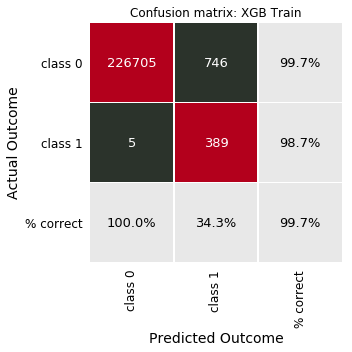

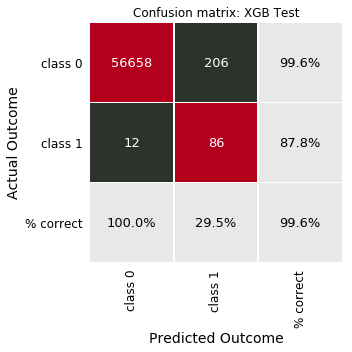

In [36]:
Confusion_Matrix(y_train,train_preds_xgb, title = 'XGB Train')
Confusion_Matrix(y_test,test_preds_xgb, title = 'XGB Test')

__Modified XGBoost - With Hist Method__

In [37]:
# Calculate precision-recall curve
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, train_preds_histxgb)
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, test_preds_histxgb)

# Calculate precision-recall AUC
auc_train = auc(recall_train, precision_train)
auc_test = auc(recall_test, precision_test)

print('The AUC PR score for Modified XGBoost algorithm on train data is : ', auc_train)
print('The AUC PR score for Modified XGBoost algorithm on test data is : ', auc_test)

The AUC PR score for Modified XGBoost algorithm on train data is :  0.8109210470852004
The AUC PR score for Modified XGBoost algorithm on test data is :  0.7778366746455782


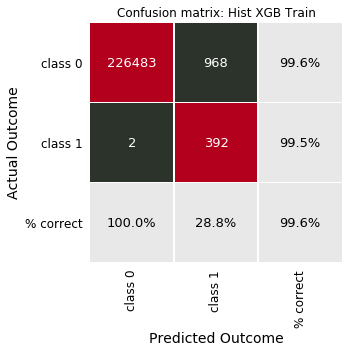

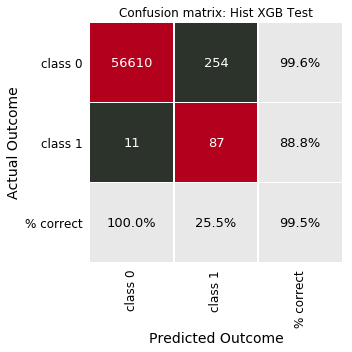

In [38]:
Confusion_Matrix(y_train,train_preds_histxgb, title = 'Hist XGB Train')
Confusion_Matrix(y_test,test_preds_histxgb, title = 'Hist XGB Test')

__Light GBM algorithm__

In [39]:
# Calculate precision-recall curve
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, train_preds_lgb)
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, test_preds_lgb)

# Calculate precision-recall AUC
auc_train = auc(recall_train, precision_train)
auc_test = auc(recall_test, precision_test)

print('The AUC PR score for Light GBM algorithm on train data is : ', auc_train)
print('The AUC PR score for Light GBM algorithm on test data is : ', auc_test)

The AUC PR score for Light GBM algorithm on train data is :  0.9434874577691575
The AUC PR score for Light GBM algorithm on test data is :  0.8861343652360033


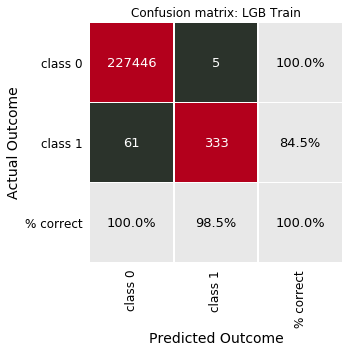

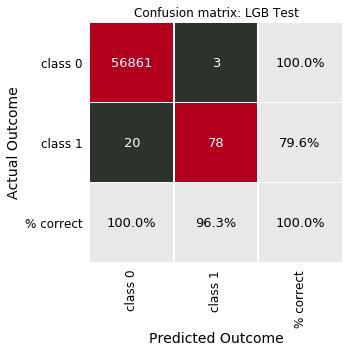

In [40]:
Confusion_Matrix(y_train,train_preds_lgb, title = 'LGB Train')
Confusion_Matrix(y_test,test_preds_lgb, title = 'LGB Test')

## Summary 

#### Run Time Comparsion (one iteration)
*  Default XGBoost -- 31.6 seconds
*  Modified XGBoost(with histogram splitting & different grow policy) -- 5.49 seconds
* Light GBM -- 1.81 seconds

#### Run Time Comparsion (hyperparameter search)
*  Default XGBoost -- 73.3 minutes
*  Modified XGBoost(with histogram splitting & different grow policy) -- 46.3 minutes
* Light GBM -- 8.8 minutes

#### Performance Comparsion (AU PRC metric on test data)
*  Default XGBoost -- 0.80
*  Modified XGBoost (with histogram splitting & different grow policy) -- 0.78
* Light GBM -- 0.88
